In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# NBER recessions
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

In [10]:
dta = pd.read_stata('https://www.stata-press.com/data/r14/rgnp.dta').iloc[1:]
print(dta)

         rgnp       date  recession
1    2.593164 1951-04-01          0
2    2.202171 1951-07-01          0
3    0.458276 1951-10-01          0
4    0.968744 1952-01-01          0
5   -0.241308 1952-04-01          0
..        ...        ...        ...
131  1.615505 1983-10-01          0
132  2.709301 1984-01-01          0
133  1.244614 1984-04-01          0
134  0.508355 1984-07-01          0
135  0.148022 1984-10-01          0

[135 rows x 3 columns]


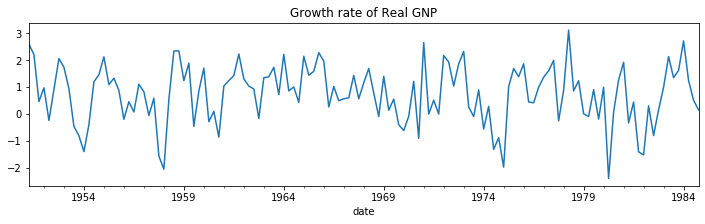

In [8]:
dta = pd.read_stata('https://www.stata-press.com/data/r14/rgnp.dta').iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq='QS')
dta_hamilton = dta.rgnp

# Plot the data
dta_hamilton.plot(title='Growth rate of Real GNP', figsize=(12,3))

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [6]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Fri, 08 May 2020   AIC                            380.527
Time:                          01:27:47   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1635      0.075     15.614      0.000       1.017       1.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5914      0.103      5.761      0.000       0.390       0.793
ar.L1          0.0135      0.120      0.112      0.911      -0.222       0.249
ar.L2         -0.0575      0.138     -0.418      0.676      -0.327       0.212
ar.L3         -0.2470      0.107     -2.310      0.021      -0.457      -0.037
ar.L4         -0.2129      0.111     -1.926      0.054      -0.430       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7547      0.097      7.819      0.000       0.565       0.944
p[1->0]        0.0959      0.038      2.542      0.011       0.022       0.170
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

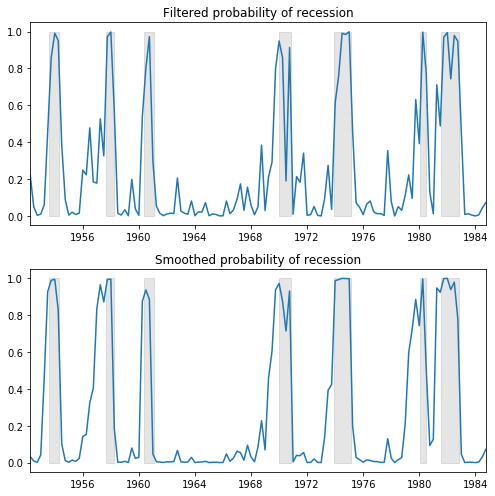

In [12]:
fig, axes = plt.subplots(2, figsize=(7,7))
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k', alpha=0.1)
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title='Filtered probability of recession')

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k', alpha=0.1)
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title='Smoothed probability of recession')

fig.tight_layout()

In [14]:
ew_excs = requests.get('http://econ.korea.ac.kr/~cjkim/MARKOV/data/ew_excs.prn').content
raw = pd.read_table(BytesIO(ew_excs), header=None, skipfooter=1, engine='python')
raw.index = pd.date_range('1926-01-01', '1995-12-01', freq='MS')

dta_kns = raw.loc[:'1986'] - raw.loc[:'1986'].mean()

print(raw)
print(dta_kns)

                   0
1926-01-01  0.020126
1926-02-01 -0.055721
1926-03-01 -0.099495
1926-04-01  0.029104
1926-05-01  0.000909
...              ...
1995-08-01  0.011167
1995-09-01  0.014978
1995-10-01 -0.040125
1995-11-01  0.019468
1995-12-01  0.016590

[840 rows x 1 columns]
                   0
1926-01-01  0.009447
1926-02-01 -0.066400
1926-03-01 -0.110174
1926-04-01  0.018425
1926-05-01 -0.009770
...              ...
1986-08-01  0.035650
1986-09-01 -0.066757
1986-10-01  0.020769
1986-11-01 -0.015699
1986-12-01 -0.039583

[732 rows x 1 columns]


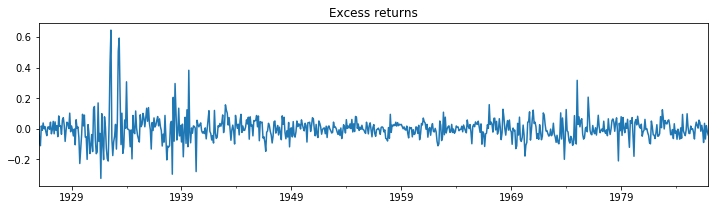

In [15]:
# Get the dataset
ew_excs = requests.get('http://econ.korea.ac.kr/~cjkim/MARKOV/data/ew_excs.prn').content
raw = pd.read_table(BytesIO(ew_excs), header=None, skipfooter=1, engine='python')
raw.index = pd.date_range('1926-01-01', '1995-12-01', freq='MS')

dta_kns = raw.loc[:'1986'] - raw.loc[:'1986'].mean()

# Plot the dataset
dta_kns[0].plot(title='Excess returns', figsize=(12, 3))

# Fit the model
mod_kns = sm.tsa.MarkovRegression(dta_kns, k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()